# Fraud Detection using Neo4j Graph Data Science
### This analysis uses Neo4j and Graph Data Science (GDS) to explore Fraudulent activites in a Peer-to-Peer (P2P) payment platform. 

In [1]:
# Import libraries
import configparser
import os
import pandas as pd
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience

pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [2]:
# Connect to local Neo4J instance
uri = "bolt://localhost:7687"
gds = GraphDataScience(uri, auth=('neo4j', 'aaaaaaaa'))

In [3]:
# Check Neo4J version
print(gds.version())
assert gds.version()

2.3.3


## Part 1: Exploring Connected Fraud Data

### **Dataset Overview**

This dataset is an anonymized sample of user accounts and transactions from a real-world Peer-to-Peer (P2P) platform. Before being imported into the graph database, original identification numbers were removed, and categorical values were masked to ensure privacy. Each user account is assigned a unique 128-bit identifier, while other nodes—representing unique credit cards, devices, and IP addresses—are assigned randomly generated UUIDs. These identifiers are stored under the `guid` property in the graph schema.

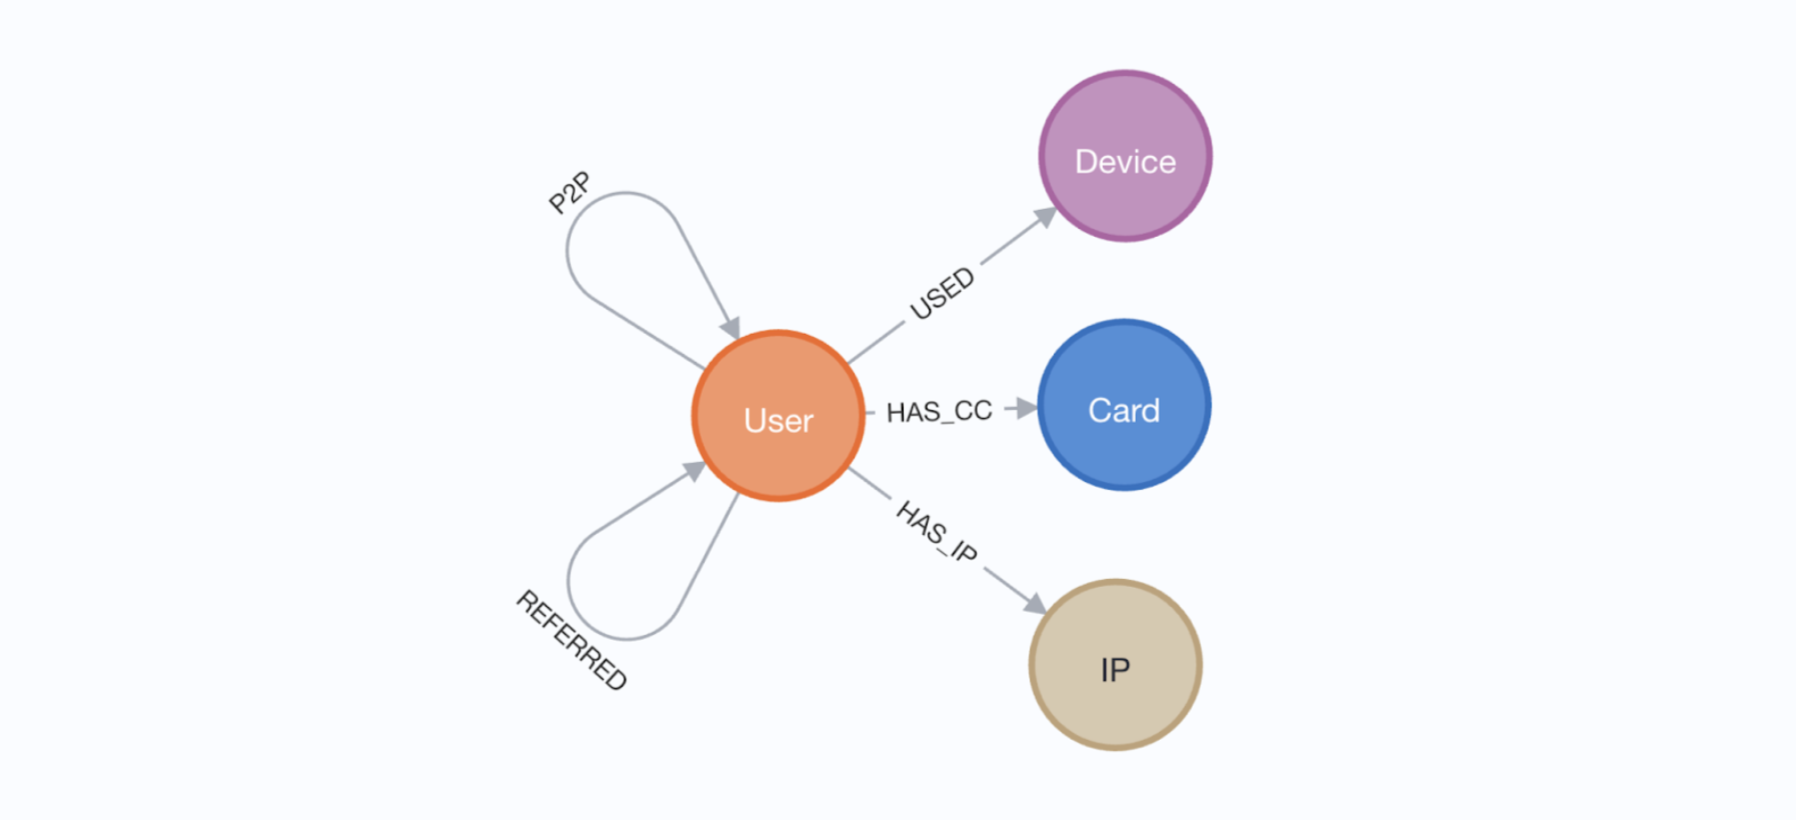

In [4]:
def clear_graph_by_name(g_name):
    if gds.graph.exists(g_name).exists:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def identifier_degrees(user_label, degree_property):
    g_name = 'id-projection'
    clear_graph_by_name(g_name)
    g, _  = gds.graph.project(g_name, [user_label, 'Card', 'Device', 'IP'],{
        'HAS_CC': {'orientation': 'REVERSE'},
        'HAS_IP': {'orientation': 'REVERSE'},
        'USED': {'orientation': 'REVERSE'}
    })
    gds.degree.mutate(g, mutateProperty=degree_property)
    gds.graph.writeNodeProperties(g, [degree_property], ['Card', 'Device', 'IP'])
    g.drop()


In this dataset, each user node has a variable called `MoneyTransferFraud` that indicates whether a user is flagged for money transfer fraud. This variable is set to `1` for known cases of fraud and `0` otherwise. The fraud status is determined based on a combination of credit card chargebacks and manual reviews. 

A **chargeback** is a reversal of an electronic payment initiated by a bank, typically as part of a dispute resolution process for billing errors or unauthorized credit card use. To be flagged as fraudulent, a user must have at least one chargeback on record. However, only a small fraction of user accounts—approximately 0.7%—are marked as fraudulent.

Below is a summary of high-level counts by labels, relationships, and the number of flagged accounts.

In [5]:
# Total Nodes
gds.run_cypher('''MATCH (n) RETURN count(n)''')

,count(n)
0,789856


In [6]:
# Total Node counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
''')

,nodeLabel,nodeCount
0,User,33732
1,Device,51451
2,Card,118818
3,IP,585855


In [7]:
# Total Relationship counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD relTypesCount
    UNWIND keys(relTypesCount) AS relationshipType
    RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
''')

,relationshipType,relationshipCount
0,USED,55026
1,HAS_IP,1488949
2,HAS_CC,128066
3,REFERRED,1870
4,P2P,102832


In [8]:
# Fraud Money Transfer flags
gds.run_cypher('MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraudMoneyTransfer, count(u) AS cnt')

,fraudMoneyTransfer,cnt
0,0,33491
1,1,241


In [9]:
# Setting a label for flagged users will enable faster lookups in cypher and faster gds projections
gds.run_cypher('MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

,count(u)
0,241


### **Exploring Fraud Patterns with Community Detection**

Given the uncertainty around fully capturing fraud through simple chargeback logic and limited connectivity, there's a possibility that not all fraudulent activity has been labeled. Fraud patterns are often complex, and fraudsters may use multiple user accounts, devices, and identifiers, making it difficult to detect their activities through single connections alone. While it’s tempting to label any account that shares a device or credit card with a flagged user as fraudulent, this approach might misclassify innocent users whose devices or cards were temporarily used by fraudsters.

In graph analysis, we can attempt to identify these fragmented, suspicious identities using **Community Detection**. Community Detection encompasses various techniques aimed at partitioning a graph into well-connected clusters, or "communities," where connections within communities are stronger than those outside. This approach helps reveal patterns of shared attributes that could indicate potential fraud networks.

In [10]:
# Use GDS degree centrality to count the number of Users connected to each identifier type - Card, Device, IP
identifier_degrees('User', 'degree')
# Use GDS degree centrality to count the number of FLAGGED Users connected to each identifier type - Card, Device, IP
identifier_degrees('FlaggedUser', 'flaggedDegree')

# Calculate the ratio of flagged users to total users
gds.run_cypher('''
    MATCH(n) WHERE n:Card OR n:Device OR n:IP
    SET n.flaggedRatio = toFloat(n.flaggedDegree)/toFloat(n.degree)
''')

""


In [11]:
print('Flagged User Ratio for Card Count')
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    WITH flaggedUserRatio, count(n) AS count, total
    RETURN flaggedUserRatio, count, round(toFloat(count)/total,3) AS percentCount 
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Card Count


,flaggedUserRatio,count,percentCount
0,0,8185,0.964
1,1,31,0.004
2,Between 0-1,274,0.032


In [12]:
print('Flagged User Ratio for Device Count')
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    WITH flaggedUserRatio, count(n) AS count, total
    RETURN flaggedUserRatio, count, round(toFloat(count)/total,3) AS percentCount 
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Device Count


,flaggedUserRatio,count,percentCount
0,0,2655,0.967
1,1,2,0.001
2,Between 0-1,88,0.032


### **Louvain Community Detection**

To explore fraud patterns, we can use **Louvain Community Detection**, a popular method in Neo4j’s Graph Data Science (GDS) library. Louvain uses modularity scoring to split a graph into hierarchical clusters, making it valuable for exploratory analysis. It does not require a precise theory of the graph structure, allowing us to investigate communities that might hold useful insights into potential fraud patterns.

For this analysis, we’ll use **P2P transactions, credit cards, and devices** to run Louvain, excluding IP addresses for now due to their “super node” issues (highly connected nodes that could skew results). By ordering communities based on the number of flagged users, we can prioritize examination of the communities with higher fraud concentrations. This approach helps us identify clusters that may contain previously undetected fraudulent activity.

Below are example queries for running Louvain in Neo4j GDS and aggregating community statistics, followed by ordering communities by the count of flagged users to identify high-risk clusters for further investigation.

In [13]:
# clear the graph if it exists beforehand
clear_graph_by_name('comm-projection')

g, _ = gds.graph.project('comm-projection', ['User','Card', 'Device'], {
    'HAS_CC': {'orientation': 'UNDIRECTED'},
    'USED': {'orientation': 'UNDIRECTED'},
    'P2P': {'orientation': 'NATURAL', 'aggregation': 'SINGLE'}
})

df = gds.louvain.write(g, writeProperty='louvainCommunityId')
g.drop()
df

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

writeMillis                                                                                                                                                                                                                                                                                                                                                                                    592
nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                                       204001
modularity                                                                                                                                                                                                                        

In [14]:
print("Louvain Communities Ordered by count of Flagged Users")
gds.run_cypher('''
    MATCH (u:User)
    WITH u.louvainCommunityId AS community,
        count(u) AS cnt,
        sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN community,
        cnt,
        flaggedCount,
        toFloat(flaggedCount)/toFloat(cnt) AS flaggedRatio
    ORDER BY flaggedCount DESC LIMIT 100
''')

Louvain Communities Ordered by count of Flagged Users


,community,cnt,flaggedCount,flaggedRatio
0,178893,206,7,0.033981
1,124966,686,4,0.005831
2,185606,7,4,0.571429
3,201222,7,3,0.428571
4,178410,3,3,1.000000
...,...,...,...,...
95,191828,6,1,0.166667
96,189798,4,1,0.250000
97,172710,2,1,0.500000
98,185625,53,1,0.018868


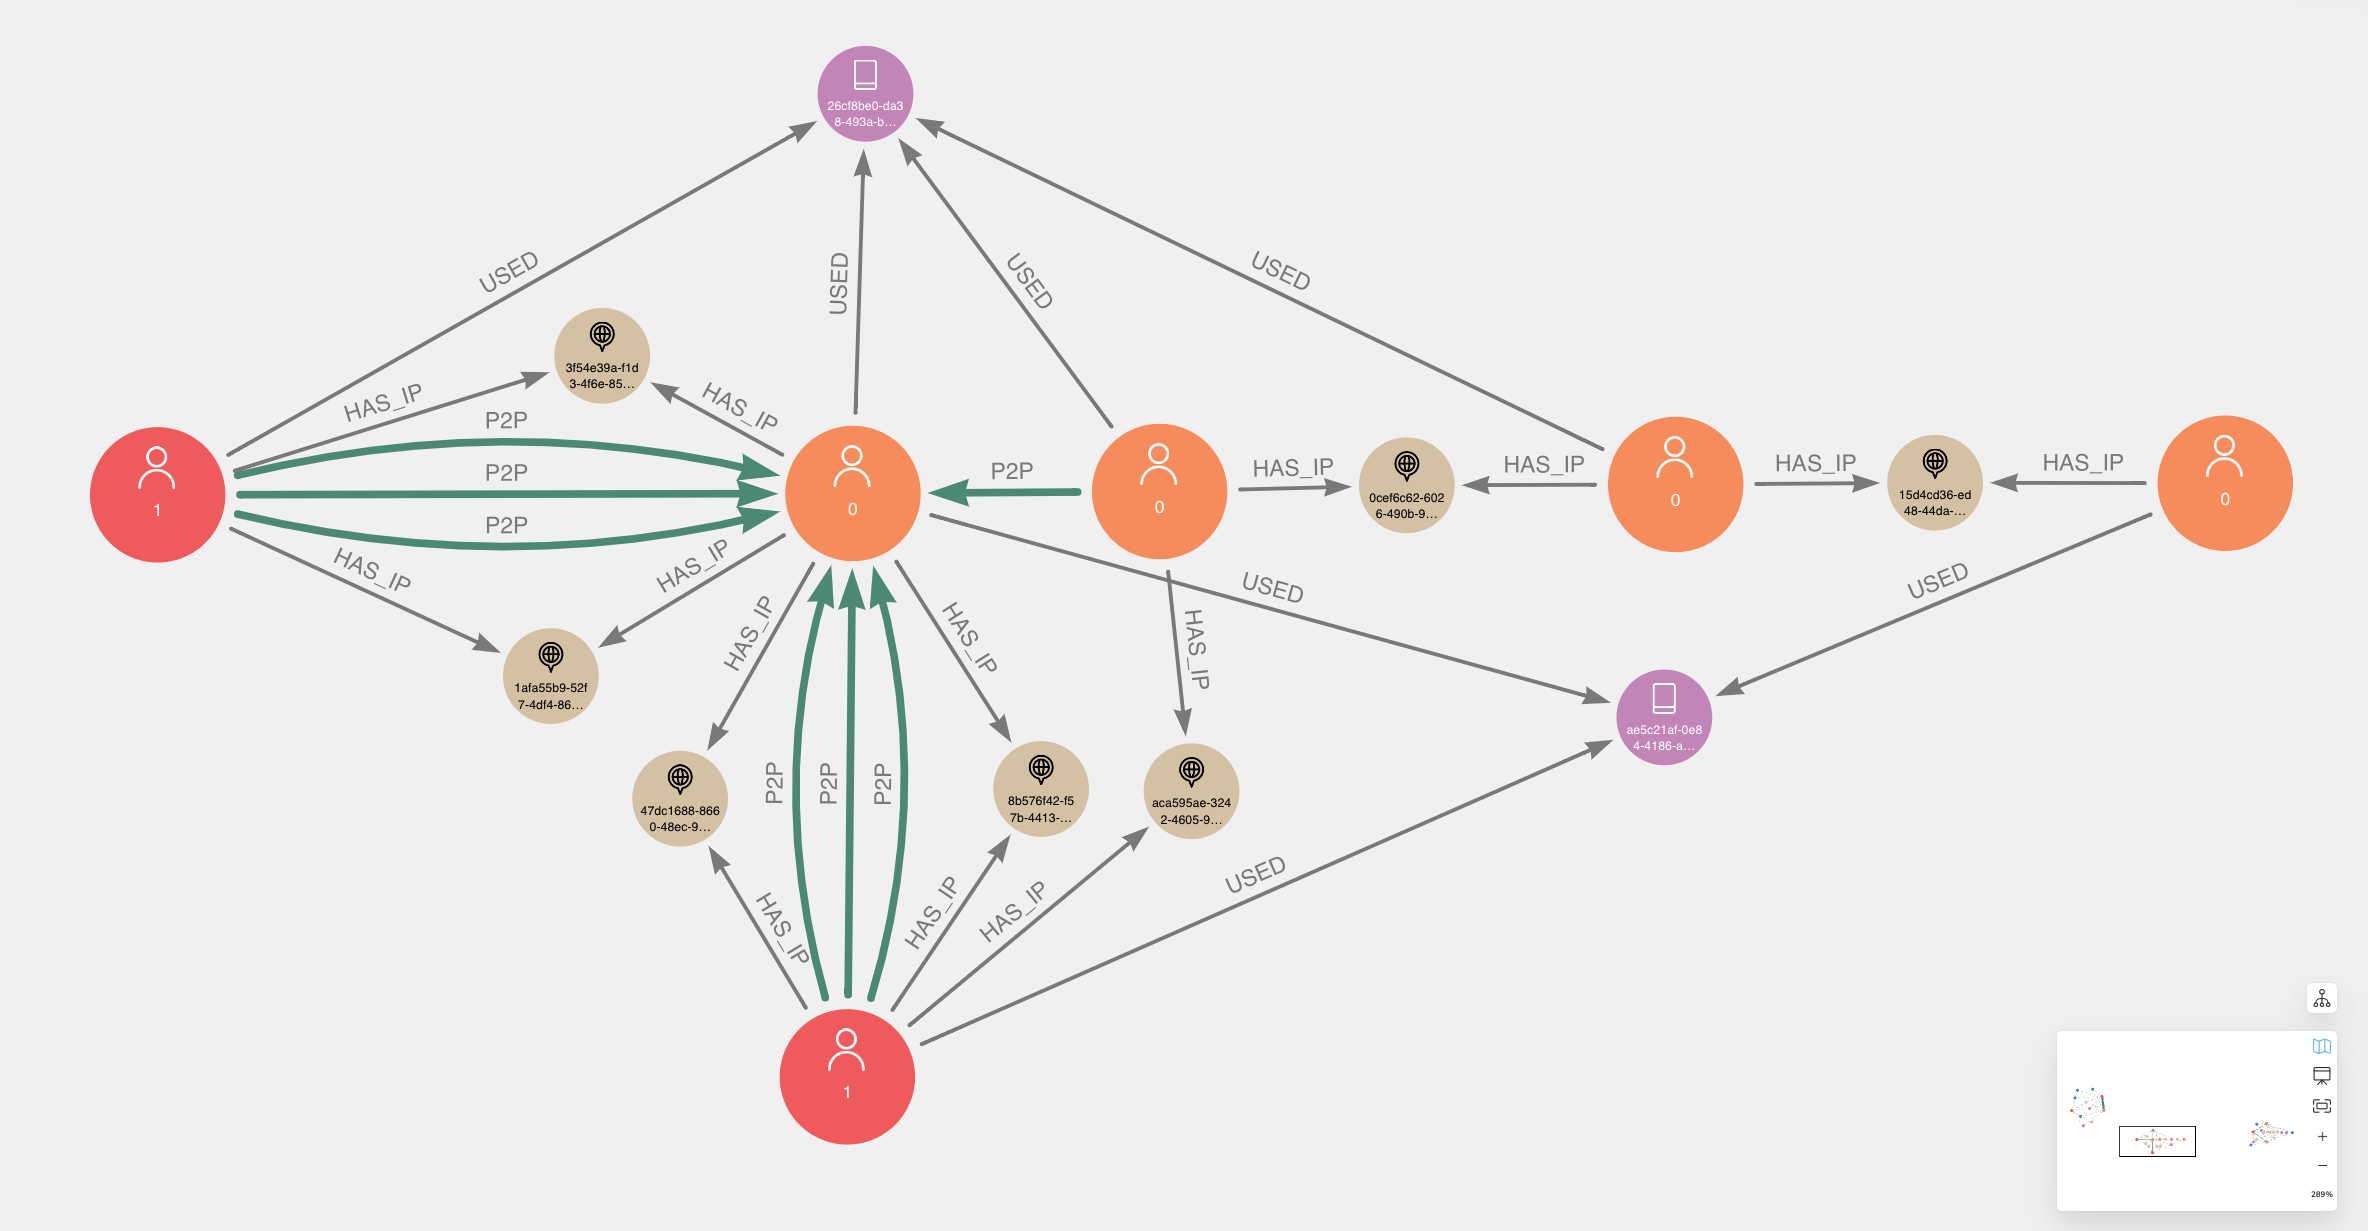

## Part 2: Resolving Fraud Communities using Entity Resolution and Community Detection

Identifying community structures that may represent underlying groups of individuals is a crucial step in fraud detection. After an initial exploration with Louvain, we will now formalize our approach using Entity Resolution (ER). ER helps define connections between users likely belonging to the same hidden group or community, allowing us to create more structured partitions.

To accomplish this, we’ll establish ER business rules that create relationships between users, reflecting likely connections. With these relationships in place, we’ll use the Weakly Connected Components (WCC) algorithm to detect communities based on these new relationships. Finally, any user within a community containing flagged accounts will be labeled as a potential fraud risk.

### **Entity Resolution Business Rules**
To identify likely groups of individuals represented by multiple accounts, we’ll define ER rules. The rules will be used to create new relationships between users who share characteristics typical of fraudulent clusters. Here’s the logic we’ll apply: Shared Transactions and Credit Cards: If a user has sent money to another user who shares the same credit card, we’ll link these accounts.


Shared Identifiers with Thresholds: If two users share:
1. A credit card or device linked to 10 or fewer total accounts
2. At least two other identifiers of type credit card, device, or IP address
...then we’ll connect them, as this likely reflects an underlying association.


These rules are only examples and can be adjusted to fit real-world conditions. 

In [15]:
# 1. P2P with shared card rule
gds.run_cypher('''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

,cnt
0,6240


In [16]:
# 2. Shared ids rule
gds.run_cypher('''
    MATCH (u1:User)-[:HAS_CC|USED]->(n)<-[:HAS_CC|USED]-(u2)
    WHERE n.degree <= 10 AND id(u1) < id(u2)
    WITH u1, u2, count(DISTINCT n) as cnt
    MATCH (u1)-[:HAS_CC|USED|HAS_IP]->(m)<-[:HAS_CC|USED|HAS_IP]-(u2)
    WITH u1, u2, count(DISTINCT m) as cnt
    WHERE cnt > 2
    MERGE(u1)-[s:SHARED_IDS]->(u2)
    RETURN count(DISTINCT s)
''')

,count(DISTINCT s)
0,5316


### **Using Weakly Connected Components (WCC) for Community Detection**

The Weakly Connected Components (WCC) algorithm is a scalable and explainable method for community detection. WCC identifies communities as sets of nodes connected by specific relationships, making it an excellent choice for fraud detection, where clear and deterministic groupings are valuable.

In our case, WCC will help resolve communities based on the Entity Resolution (ER) relationships we created. This approach allows us to assign formal community labels to users, grouping them into connected clusters that may reveal hidden fraud patterns. Users within the same WCC cluster can be considered part of the same community, which is helpful in identifying and examining groups likely to involve fraud.

In [17]:
# clear the graph if it exists beforehand
clear_graph_by_name('comm-projection')

g, _ = gds.graph.project('comm-projection', ['User'], {
    'SHARED_IDS': {'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}
})

df = gds.wcc.write(g, writeProperty='wccId')
g.drop()
df

writeMillis                                                                                                                                                                                                                                                                                      64
nodePropertiesWritten                                                                                                                                                                                                                                                                         33732
componentCount                                                                                                                                                                                                                                                                                28203
componentDistribution                                                                                                       

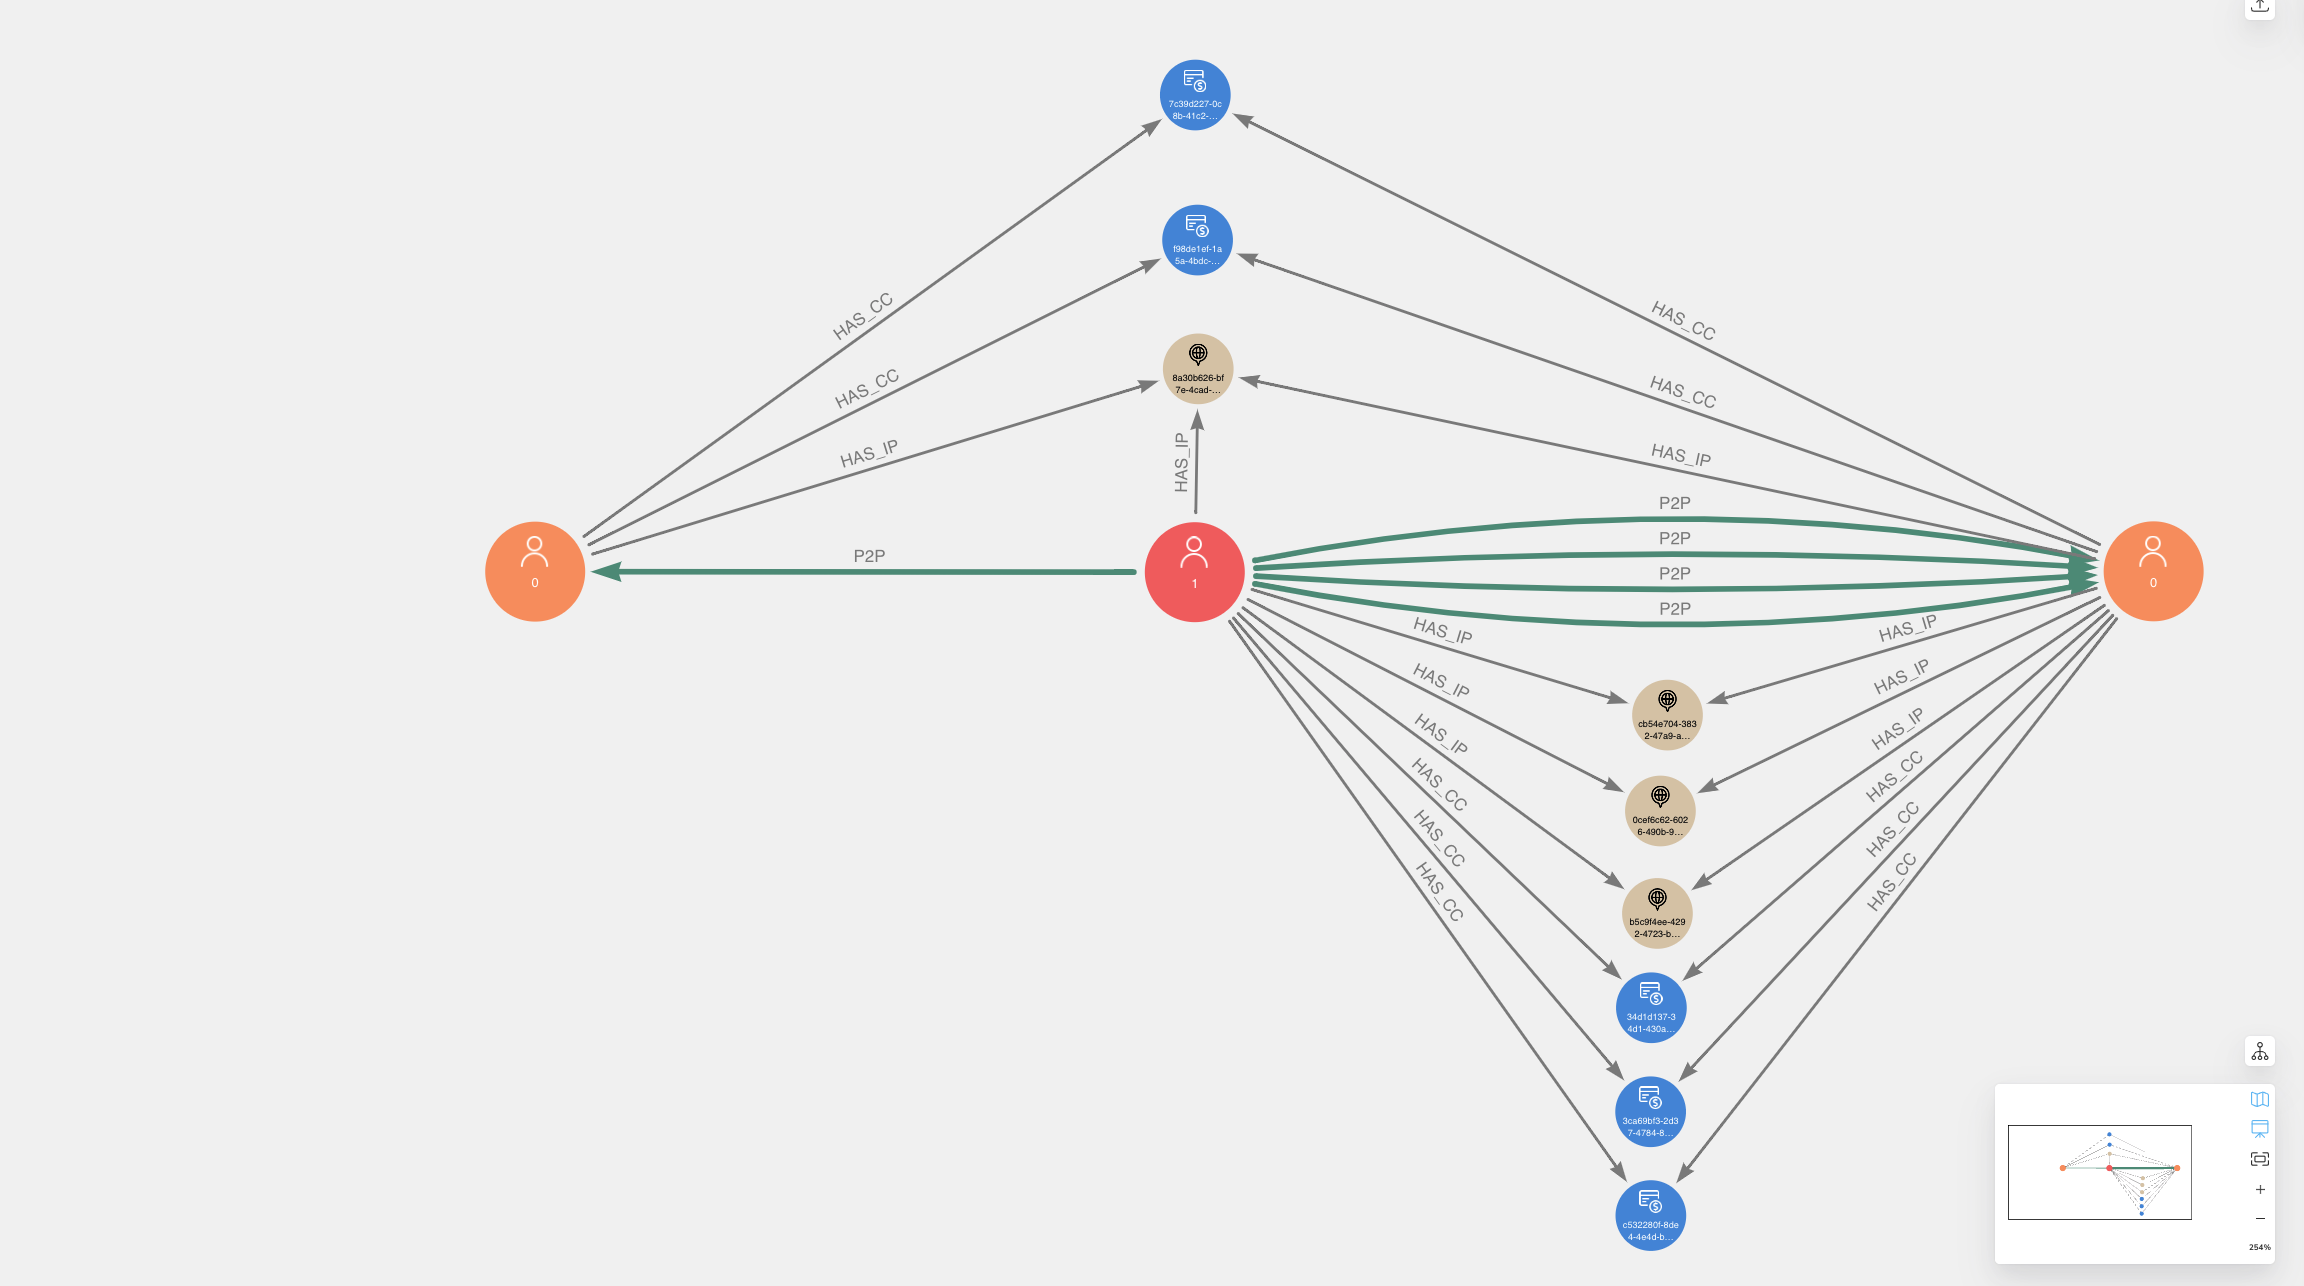

### **Labeling Fraud Risk User Accounts**
As these communities are meant to label underlying groups of individuals, if even one flagged account is in the community, we will label all user accounts in the group as fraud risks:

In [18]:
# Count of fraud risk users
gds.run_cypher('''
    MATCH (f:FlaggedUser)
    WITH collect(DISTINCT f.wccId) AS flaggedCommunities
    MATCH(u:User) WHERE u.wccId IN flaggedCommunities
    SET u:FraudRiskUser
    SET u.fraudRisk=1
    RETURN count(u)
''')


,count(u)
0,452


In [19]:
# Count of non-fraud risk users
gds.run_cypher('''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
    RETURN count(u)
''')

,count(u)
0,33280


### **WCC Community Statistics**
The community size distribution is as follows: most communities consist of a single user, with only a small number containing multiple users. Among the multi-user communities, the majority are small, with sizes of 2 or 3. Larger communities are uncommon. However, when we examine the fraudUser accounts, we find that most of them are located in multi-user communities. The 118 fraud accounts in single-user communities are flagged based on the original chargeback logic and have not yet been assigned to a community.

In [20]:
gds.run_cypher( '''
    MATCH (u:User)
    WITH u.wccId AS community, count(u) AS cSize, sum(u.fraudRisk) AS cFraudSize
    WITH community, cSize, cFraudSize,
    CASE
        WHEN cSize=1 THEN ' 1'
        WHEN cSize=2 THEN ' 2'
        WHEN cSize=3 THEN ' 3'
        WHEN cSize>3 AND cSize<=10 THEN ' 4-10'
        WHEN cSize>10 AND cSize<=50 THEN '11-50'
        WHEN cSize>10 THEN '>50' END AS componentSize
    RETURN componentSize, 
        count(*) AS numberOfComponents, 
        sum(cSize) AS totalUserCount, 
        sum(cFraudSize) AS fraudUserCount 
    ORDER BY componentSize
''')

,componentSize,numberOfComponents,totalUserCount,fraudUserCount
0,1,24283,24283,118
1,2,3165,6330,144
2,3,481,1443,63
3,4-10,258,1246,68
4,11-50,15,255,59
5,>50,1,175,0


### **Outcomes of Fraud Risk Labeling**
Fraud Risk labeling helped identify an additional 211 new fraud risk user accounts, nearly doubling the number of known fraud users (87.5% increase). We also see that 65% of the money going to/from previously flagged accounts and other users can be attributed to the newly identified risk accounts:

In [21]:
gds.run_cypher('''
   MATCH (:FlaggedUser)-[r:P2P]-(u)  WHERE NOT u:FlaggedUser
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-(:FlaggedUser) WHERE NOT u:FlaggedUser
   WITH p2pTotal,  toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.652

Additionally, while the newly identified 211 accounts represents less than 1% of total users in the sample, 12.7% of the total P2P amount in the sample involved the newly identified accounts as senders or receivers:

In [22]:
gds.run_cypher('''
   MATCH (:User)-[r:P2P]->()
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-() WHERE NOT u:FlaggedUser
   WITH p2pTotal, toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.127

The aggregate P2P statistics combined with improvements in Card and Device metrics are significant given the limited scope of the previously flagged fraud which focused on chargebacks. These results strongly imply that there are more sophisticated networks of fraudulent money flows behind the chargebacks rather than the chargebacks being isolated occurrences.

In [24]:
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    WITH fraudRiskRatio, count(n) AS count, total
    RETURN fraudRiskRatio, count, round(toFloat(count)/total,3) AS percentCount 
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,8114,0.956
1,1,351,0.041
2,Between 0-1,25,0.003


In [25]:
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    WITH fraudRiskRatio, count(n) AS count, total
    RETURN fraudRiskRatio, count, round(toFloat(count)/total,3) AS percentCount 
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,2605,0.949
1,1,92,0.034
2,Between 0-1,48,0.017


## Part 3: Recommending Suspicious Accounts With Centrality & Node Similarity

In parts 1 and 2, we explored the graph to identify high-risk fraud communities. Now, we can go a step further by automatically identifying users that are suspiciously similar to the fraud risks already flagged. By expanding our analysis to include centrality and similarity algorithms, we can triage and recommend additional suspect users quickly and efficiently. Neo4j and Graph Data Science (GDS) provide an easy way to achieve this in seconds.

### **Using Weighted Degree Centrality to Recommend Potential High-Risk Accounts**
One approach to identifying suspicious users is to use Weighted Degree Centrality. This algorithm ranks users based on their connectedness in the graph, considering the importance of their relationships with key identifiers (e.g., Devices, Cards, and IP addresses). We can enhance the centrality calculation by weighting the degree centrality with the fraudRiskRatios we created in part 2. This will help prioritize users that are more likely to be connected to known fraud risks.

In [26]:
gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(u:User)-[:HAS_CC|HAS_IP|USED]->(n) WHERE NOT u:FraudRiskUser
    WITH left(u.guid,8) as uid,
        sum(n.fraudRiskRatio) AS totalIdFraudRisk,
        count(n) AS numberFraudRiskIds
    WITH uid, totalIdFraudRisk,
        numberFraudRiskIds,
        totalIdFraudRisk/toFloat(numberFraudRiskIds) AS averageFraudIdRisk
    WHERE averageFraudIdRisk >= 0.25
    RETURN uid, totalIdFraudRisk, numberFraudRiskIds, averageFraudIdRisk
    ORDER BY totalIdFraudRisk DESC LIMIT 10
''')

,uid,totalIdFraudRisk,numberFraudRiskIds,averageFraudIdRisk
0,50fd11c0,7.405512,28,0.264483
1,b41b9e3b,6.487978,22,0.294908
2,a982e8fc,3.928543,13,0.302196
3,60b71ab9,2.020481,7,0.288640
4,bc1eb835,2.010309,5,0.402062
5,1b1a78a9,1.925455,5,0.385091
6,f2b8a068,1.693794,6,0.282299
7,1c773976,1.594978,5,0.318996
8,a2f748e3,1.570455,4,0.392614
9,7524a090,1.527338,5,0.305468


### **Expanding on Fraud Communities Using Node Similarity**

While simple centrality measures like weighted degree centrality are useful for identifying suspicious users across the entire graph, they might not be sufficient when we are interested in users connected to specific fraud risk communities. It’s possible that communities of fraud-risk users are larger than initially identified, but without clear business rules to apply, we can turn to similarity algorithms to help us score and recommend potential users for inclusion in these communities.

Neo4j Graph Data Science (GDS) offers various similarity algorithms, and for this analysis, we’ll focus on the Node Similarity algorithm. This method is explainable, scalable, and uses a straightforward Jaccard similarity calculation to identify pairs of nodes that are similar based on shared connections. Unlike machine learning-based approaches like FastRP + KNN, which are better for very large global graphs, Node Similarity excels when we can focus the analysis on a subset of data, such as users connected to a specific fraud-risk community.

In this analysis, we will focus on nodes (Cards, Devices, and IP addresses) that are connected to at least one fraud-risk user from Part 2. This will help us identify users that share connections with flagged fraud-risk accounts, further expanding our community detection.

In [27]:
# label identifiers and users that are close to fraud risk users and assign inverse degree weight
gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(n)<-[r:HAS_CC|HAS_IP|USED]-(u)
    SET n:FraudSharedId
    SET r.inverseDegreeWeight = 1.0/(n.degree-1.0)
    RETURN count(DISTINCT n)
''')

,count(DISTINCT n)
0,18182


In [28]:
# clear the graph if it exists beforehand
clear_graph_by_name('similarity-projection')

g, _ = gds.graph.project('similarity-projection', ['User', 'FraudSharedId'], ['HAS_CC', 'USED', 'HAS_IP'],
                         relationshipProperties=['inverseDegreeWeight'])



df = gds.nodeSimilarity.write(g, writeRelationshipType='SIMILAR_IDS', writeProperty='score',
                              similarityCutoff=0.01, relationshipWeightProperty='inverseDegreeWeight')
g.drop()
df

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                                                                                                                                                                                                                                                                                                                                                                                                            0
computeMillis                                                                                                                                                                                                                                                                                                                                                                                                                                              37196
writeMillis                                                                                           

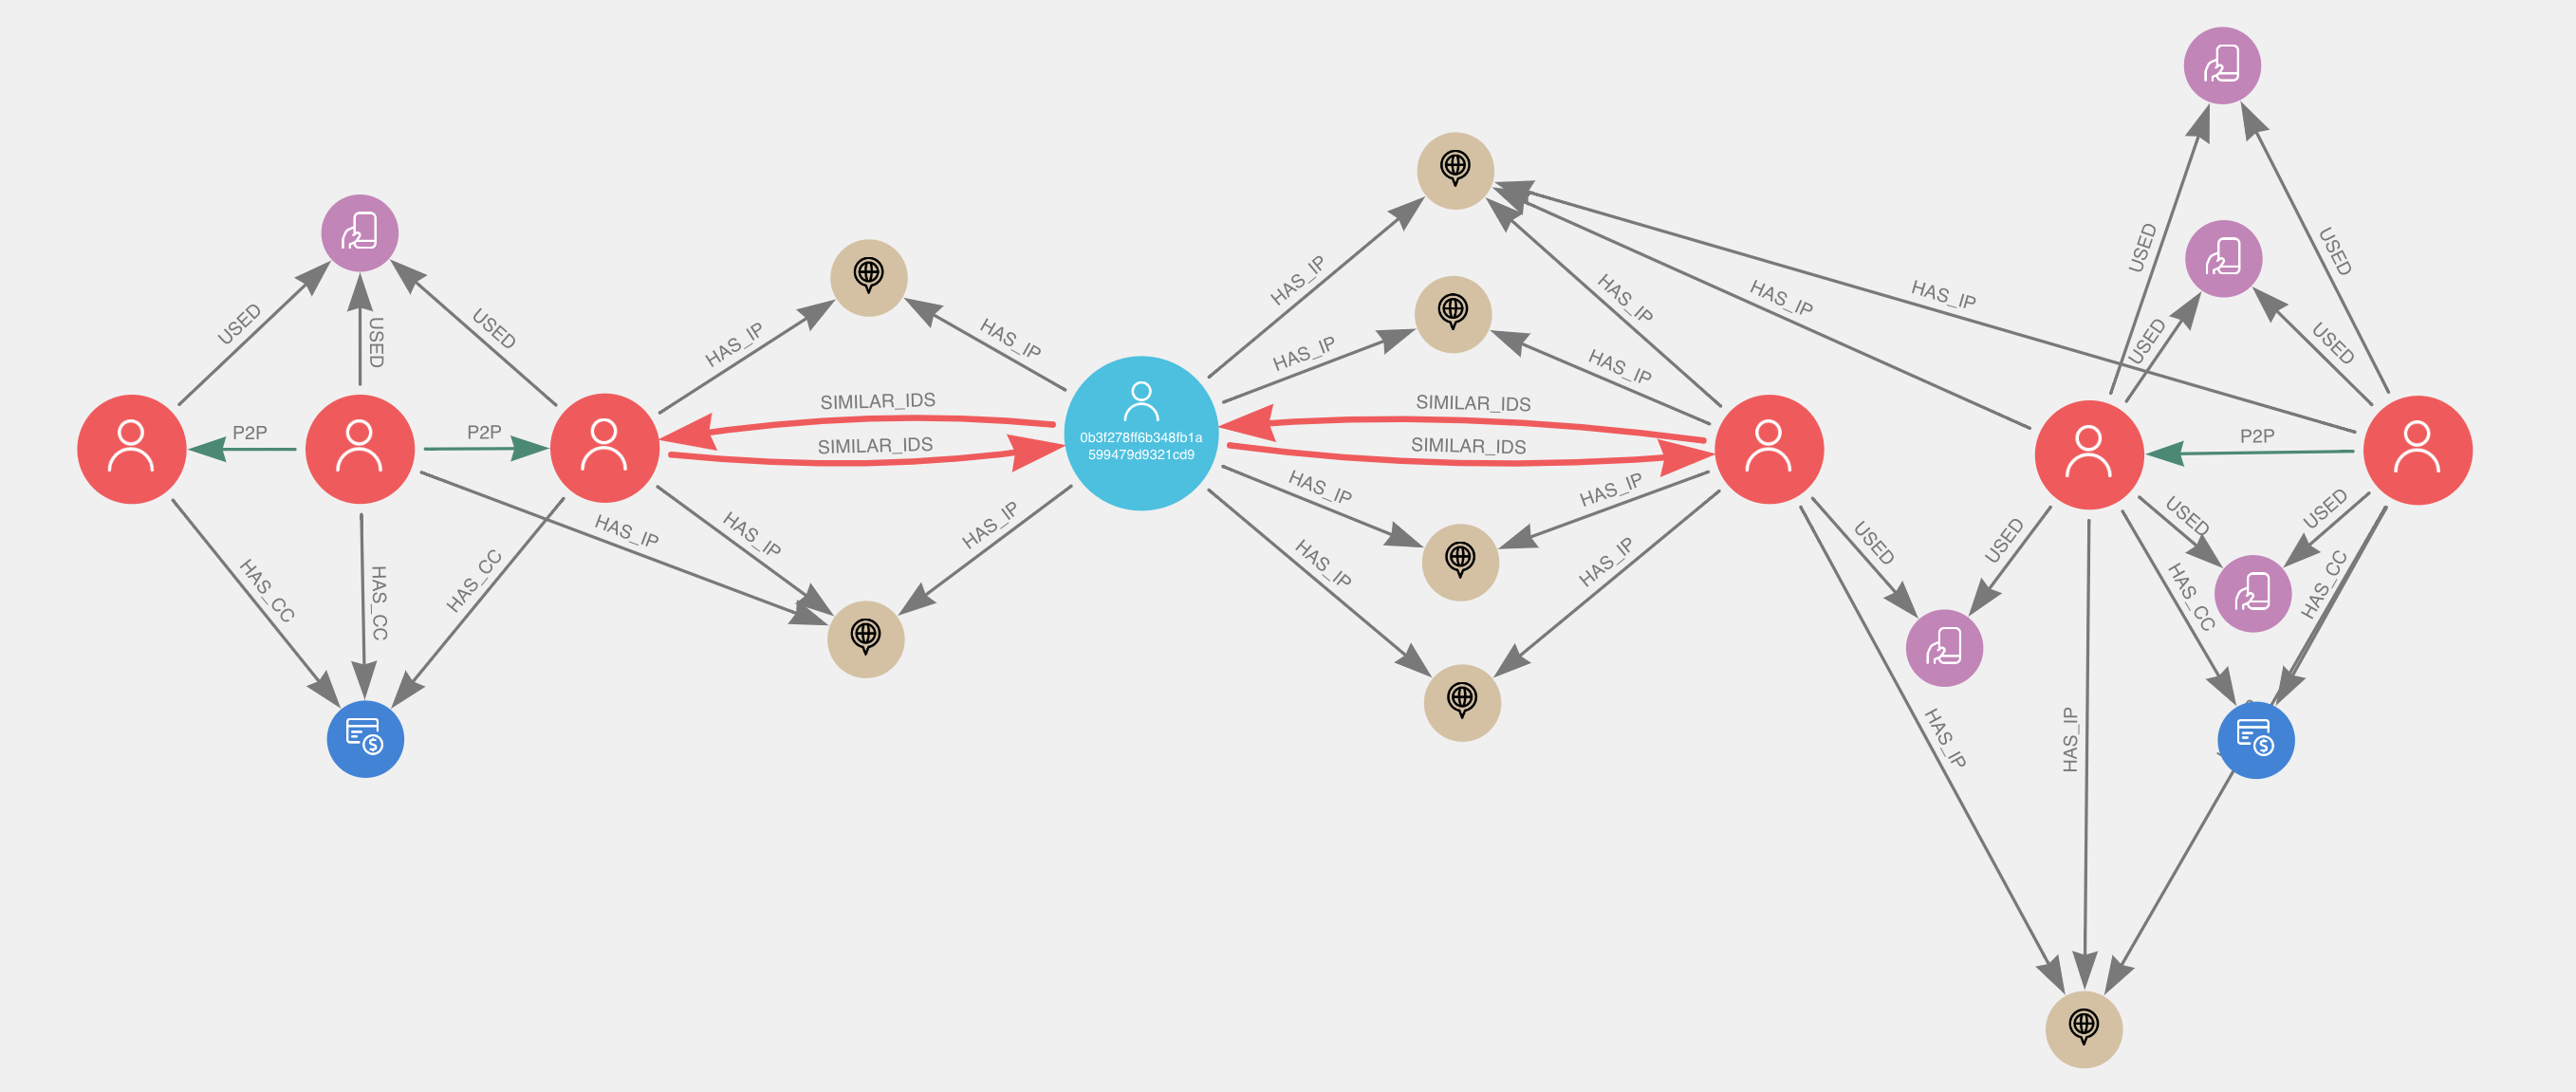

In [29]:
# Get nodes similar to the high risk ones
gds.run_cypher('''
    MATCH (f:FraudRiskUser)
    WITH f.wccId AS componentId, count(*) AS numberOfUsers, collect(f) AS users
    UNWIND users AS f
    MATCH (f)-[s:SIMILAR_IDS]->(u:User) WHERE NOT u:FraudRiskUser AND numberOfUsers > 2
    RETURN u.guid AS userId, sum(s.score) AS totalScore, collect(DISTINCT componentId) AS closeToCommunityIds 
    ORDER BY totalScore DESC
''')

,userId,totalScore,closeToCommunityIds
0,0b3f278ff6b348fb1a599479d9321cd9,0.427332,"[4616, 4932]"
1,c0d80bb57c0bbb0b68f647c7adc83274,0.298319,[4932]
2,99d857cf888723db4ab2c19e42ac2b4c,0.260633,[4616]
3,6b41e66c7667df06c10eab6c6b712fec,0.201825,[4932]
4,55447b3000b48335d3b18557c43ba70a,0.136346,[4616]
5,8c7fb38c22da0e7ad8d91a8551f62e4c,0.136169,[477]
6,f0ec0c4c8cf74ebdf1ace4c366e58873,0.111970,[4616]
7,f3c3fa16c8d095c257452f3287991cef,0.082760,[4616]
8,48ab157818d5d6e31d4808e624a93846,0.077805,[4616]
9,a2f748e3e52915b9aff50f9af628a9ee,0.075465,[477]


In [30]:
gds.run_cypher('''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity;
''')

""


In [31]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# Payment Centrality & Influence Features
g, _ = gds.graph.project('p2p-features', ['User'], {
    'P2P': {'type': 'P2P', 'orientation': 'NATURAL', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'P2P_REVERSE': {'type': 'P2P', 'orientation': 'REVERSE', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'SHARED_IDS': {'type': 'SHARED_IDS', 'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'type': 'P2P_WITH_SHARED_CARD', 'orientation': 'NATURAL'}
})
gds.degree.write(g, relationshipTypes=['SHARED_IDS'], writeProperty='sharedIdsDegree')
gds.pageRank.write(g, relationshipTypes=['P2P_WITH_SHARED_CARD'], maxIterations=1000,
                   writeProperty='p2pSharedCardPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P'], maxIterations=1000, writeProperty='p2pSentPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P_REVERSE'], maxIterations=1000, relationshipWeightProperty='totalAmount',
                   writeProperty='p2pReceivedWeightedPageRank')
gds.degree.write(g, relationshipTypes=['P2P_REVERSE'], relationshipWeightProperty='totalAmount',
                 writeProperty='p2pReceivedWeightedDegree')
g.drop()

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       p2p-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [32]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# User Id Centrality Features
g, _ = gds.graph.project('user-centrality-features', ['User', 'Card', 'Device', 'IP'], ['HAS_CC', 'HAS_IP', 'USED'])
gds.degree.mutate(g, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'], mutateProperty='cardDegree')
gds.degree.mutate(g, nodeLabels=['User', 'Device'], relationshipTypes=['USED'], mutateProperty='deviceDegree')
gds.degree.mutate(g, nodeLabels=['User', 'IP'], relationshipTypes=['HAS_IP'], mutateProperty='ipDegree')
gds.graph.writeNodeProperties(g, ['cardDegree', 'deviceDegree', 'ipDegree'], ['User'])
g.drop()

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           user-centrality-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## **Part 4: Predicting Fraud Risk Accounts with Machine Learning**

In real-world fraud detection scenarios, it's often difficult to identify fraudulent user accounts ahead of time. In some cases, like with this dataset, accounts are flagged for fraud based on **business rules**—such as chargeback history—or through **user reporting mechanisms.** However, as we observed in Parts 1 and 2, these flags alone may not provide a complete picture. While **community detection** and **recommendation techniques** have helped uncover hidden fraud patterns, there are still instances where additional fraudulent accounts might go undetected by business rules alone.

Supervised **Machine Learning (ML)** can be highly beneficial in these situations. It allows us to predict fraud risk by using labeled data to train models that can recognize patterns of fraud and identify new fraud risks proactively. Here’s why integrating supervised ML is valuable:

### 1. **Proactive Detection**
   - By training a machine learning model, we can **anticipate fraud** before traditional flags such as chargebacks are triggered or new reports come in. This allows us to identify fraudulent actors even if they are not yet linked to known fraudulent accounts.
   - The model can detect **emerging fraud trends** or new communities of fraudsters that aren’t connected to older fraud patterns, providing more comprehensive coverage for fraud prevention.

### 2. **Measurable Performance**
   - Unlike heuristic or rule-based approaches, **supervised learning** models produce **clear performance metrics**—such as accuracy, precision, recall, and F1-score—that allow us to evaluate how well the model is identifying fraud risk.
   - These metrics give us a **benchmark** to assess the model’s effectiveness and adjust it as needed, whether through **hyperparameter tuning**, using more data, or experimenting with different features.

### 3. **Automation**
   - **Supervised Machine Learning** automates the **process of predicting fraud risk** accounts. Once a model is trained, it can score new user accounts in real-time, reducing the reliance on manual intervention or rule-based decision-making. This enhances **operational efficiency** and allows the fraud detection system to scale.
   - The automation also ensures that the fraud detection system **remains consistent** and free of human bias, helping to maintain fair decision-making processes.

### The Role of Supervised ML in Fraud Detection

Using labeled fraud data (fraudulent or not), we can train supervised machine learning models to recognize patterns associated with fraud. This involves:

1. **Feature Engineering:** Creating features such as transaction behavior, user activity, network centrality, and other graph-based features that can help the model identify fraudulent patterns.
2. **Training:** Feeding the labeled data into machine learning models like decision trees, logistic regression, or more advanced methods like Random Forests, Gradient Boosting, or neural networks.
3. **Evaluation:** Evaluating the model using metrics like **confusion matrix**, **ROC-AUC**, and **precision-recall curve** to understand how well the model is identifying fraud and non-fraud accounts.
4. **Prediction:** Once trained, the model can predict whether new, unseen accounts are likely to be fraudulent, allowing fraud teams to take preventative action.

By combining machine learning with the techniques we’ve used in previous sections—such as **community detection** and **entity resolution**—we can create a more robust fraud detection system that **automatically** adapts to new fraud patterns and helps prioritize fraud investigation efforts.


In [33]:
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,f3693169dcc9064114a171c5c2f485b5,32798,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,10f7f048645c602de3fae7c2cf81b254,29031,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,d3a4469957800636802a8de4874af1bc,32800,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,4698ccb2e4b07b1974741f634115e49b,32801,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [34]:
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
y = df.fraudRisk - df.fraudMoneyTransfer

In [35]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33727    0
33728    0
33729    0
33730    0
33731    0
Length: 33732, dtype: int64


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### **Model Training and Evaluation**

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import RocCurveDisplay


model_1 = LogisticRegression()
model_2 = XGBClassifier()
model_3 = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
model_5 = DecisionTreeClassifier(random_state=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)

/Users/sravani/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier(random_state=0)

Accuracy of Log Reg classifier on test set: 0.99

Confusion Matrix: 


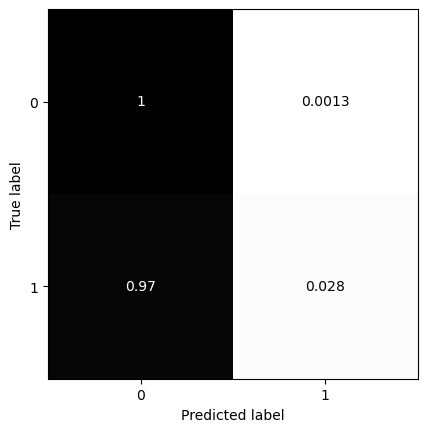

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of Log Reg classifier on test set: {:.2f}'.format(model_1.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, model_1.predict(X_test), display_labels=model_1.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

Accuracy of XGB on test set: 1.00

Confusion Matrix: 


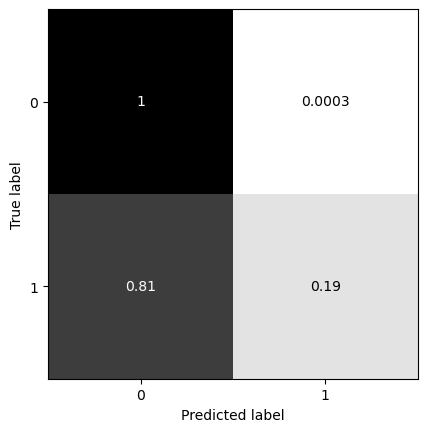

In [82]:
print('Accuracy of XGB on test set: {:.2f}'.format(model_2.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, model_2.predict(X_test), display_labels=model_2.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

Accuracy of random forrest classifier on test set: 0.85

Confusion Matrix: 


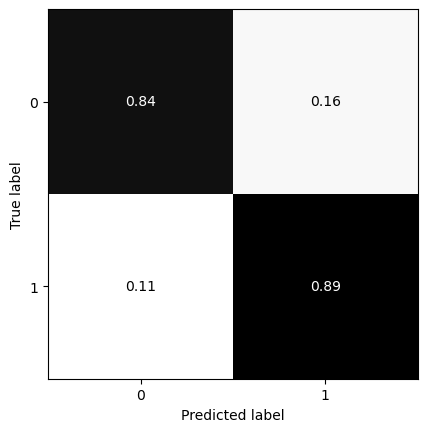

In [83]:
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(model_3.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, model_3.predict(X_test), display_labels=model_3.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

Accuracy of DT on test set: 0.99

Confusion Matrix: 


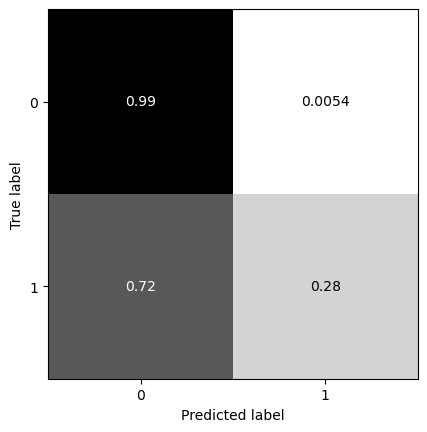

In [84]:
print('Accuracy of DT on test set: {:.2f}'.format(model_4.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, model_4.predict(X_test), display_labels=model_4.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

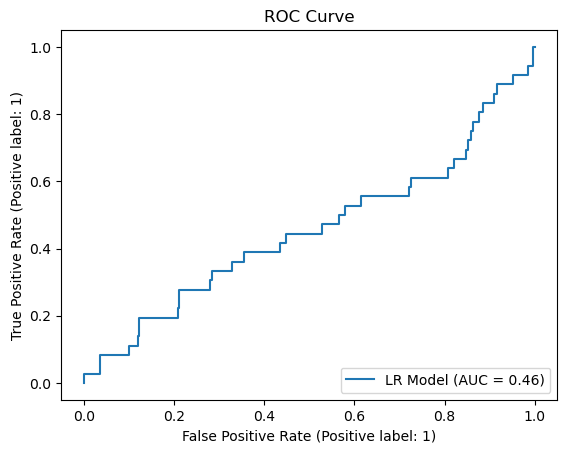

In [85]:
display = RocCurveDisplay.from_estimator(model_1, X_test, y_test, name="LR Model")
_ = display.ax_.set_title("ROC Curve")

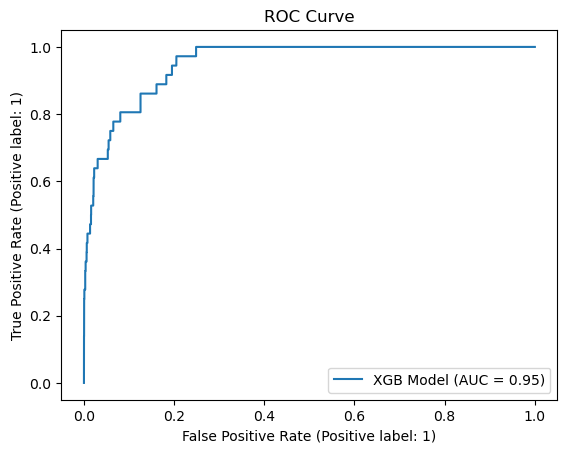

In [86]:
display = RocCurveDisplay.from_estimator(model_2, X_test, y_test, name="XGB Model")
_ = display.ax_.set_title("ROC Curve")

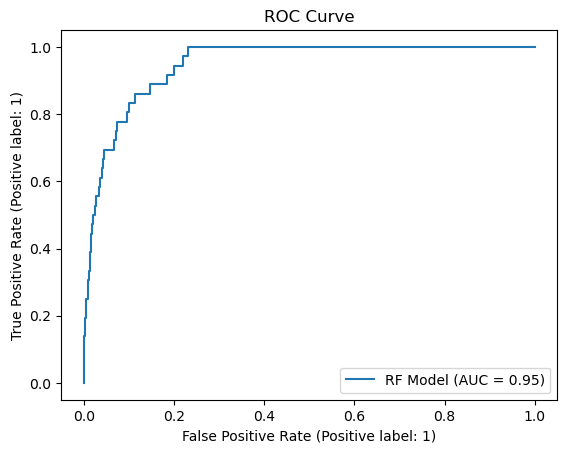

In [87]:
display = RocCurveDisplay.from_estimator(model_3, X_test, y_test, name="RF Model")
_ = display.ax_.set_title("ROC Curve")

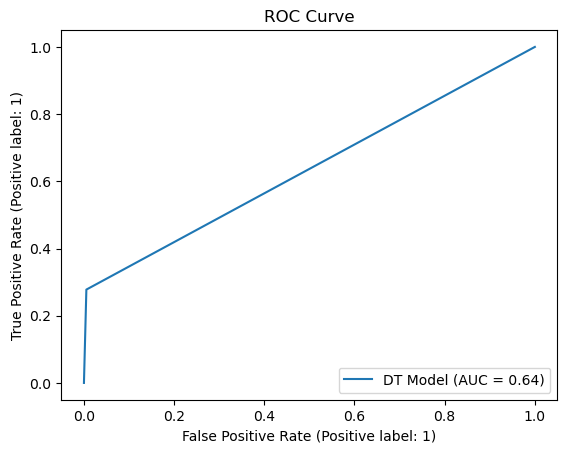

In [88]:
display = RocCurveDisplay.from_estimator(model_4, X_test, y_test, name="DT Model")
_ = display.ax_.set_title("ROC Curve")

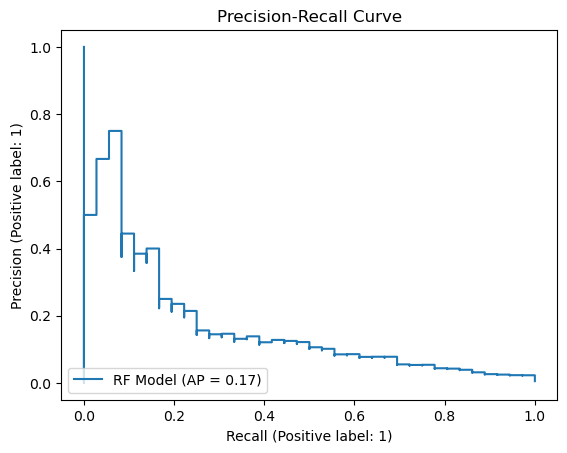

In [64]:
from sklearn.metrics import PrecisionRecallDisplay

y_prob = model_3.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob[:, 1], name="RF Model")
_ = display.ax_.set_title("Precision-Recall Curve")

In [65]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_3, X_train, y_train, random_state=0)
pd.DataFrame(abs(result['importances_mean']),index=X_train.columns).sort_values(0, ascending=False)

,0
communitySize,0.106526
partOfCommunity,0.096765
sharedIdsDegree,0.018892
p2pSharedCardPageRank,0.016861
ipDegree,0.008471
cardDegree,0.004484
deviceDegree,0.002431
p2pReceivedWeightedPageRank,0.002268
p2pSentPageRank,0.002031
p2pReceivedWeightedDegree,0.001319


In [66]:
# Retrieve High Probability predictions for non-fraud risk labeled data in the testset
y_test_df = y_test.to_frame(name='cls')
y_test_df['predictedProbability']=y_prob[:, 1]
test_prob_df = y_test_df[(y_test_df.predictedProbability > 0.88) & (y_test_df.cls == 0)] \
    .join(df[['guid','wccId', 'communitySize']])
test_prob_df

,cls,predictedProbability,guid,wccId,communitySize
3724,0,0.881712,50ad7d70bb174a8f95d06d5067db1bba,2391,5
10344,0,0.880321,bf39047c8f385a0a6657217c1b052858,148,7
21326,0,0.896839,c4d3c05ebf06a6b7b2f10833a51a0b70,15742,4


### **Clean Up**
I will  clean all the additional graph elements and properties created in the above workflow.

In [ ]:
#Write back to database for investigation in Bloom
for index, row in test_prob_df.iterrows():
    gds.run_cypher('''
        MATCH(u:User) WHERE u.guid = $guid
        SET u.predictedProbability = $predictedProbability
    ''', params = row.to_dict())

In [ ]:
# delete created relationships
gds.run_cypher('MATCH (:User)-[r:SHARED_IDS]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:P2P_WITH_SHARED_CARD]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:SIMILAR_IDS]->() DELETE r')

In [ ]:
# remove created node Labels
gds.run_cypher('MATCH (u:FlaggedUser) REMOVE u:FlaggedUser')
gds.run_cypher('MATCH (u:FraudRiskUser) REMOVE u:FraudRiskUser')
gds.run_cypher('MATCH (u:FraudSharedId) REMOVE u:FraudSharedId')

In [ ]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.wccId,
        n.sharedIdsDegree,
        n.predictedProbability,
        n.partOfCommunity,
        n.p2pSharedCardPageRank,
        n.p2pSharedCardDegree,
        n.p2pSentWeightedPageRank,
        n.p2pSentWeightedDegree,
        n.p2pSentPageRank,
        n.p2pSentDegree,
        n.p2pReversedSharedCardPageRank,
        n.p2pReversedSharedCardDegree
        
''')


In [ ]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.p2pReceivedWeightedPageRank,
        n.p2pReceivedWeightedDegree,
        n.p2pReceivedPageRank,
        n.p2pReceivedDegree,
        n.louvainCommunityId,
        n.ipDegree,
        n.fraudRiskRatio,
        n.fraudRiskDegree
''')

In [ ]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.fraudRisk,
        n.flaggedRatio,
        n.flaggedDegree,
        n.deviceDegree,
        n.degree,
        n.communitySize,
        n.cardDegree
''')

In [ ]:
# remove created relationship properties
gds.run_cypher('MATCH ()-[r]->() REMOVE r.inverseDegreeWeight')